### What is image segmentation?
In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

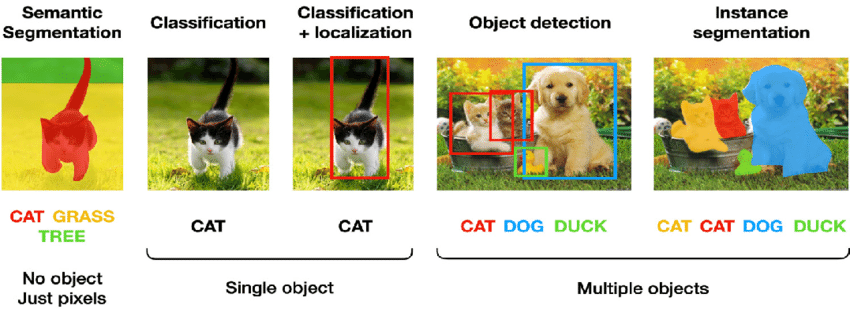

ref: https://www.tensorflow.org/tutorials/images/segmentation\

### Deep learning image segmentation
1. Semantic segmentation: Semantic segmentation is the simplest type of image segmentation. A semantic segmentation model assigns a semantic class to every pixel, but doesn’t output any other context or information (like objects).

2. Instance segmentation: Instance segmentation inverts the priorities of semantic segmentation: whereas semantic segmentation algorithms predict only semantic classification of each pixel (with no regard for individual instances), instance segmentation delineates the exact shape of each separate object instance.

3. Panoptic segmentation: Panoptic segmentation models both determine semantic classification of all pixels and differentiate each object instance in an image, combining the benefits of both semantic and instance segmentation.

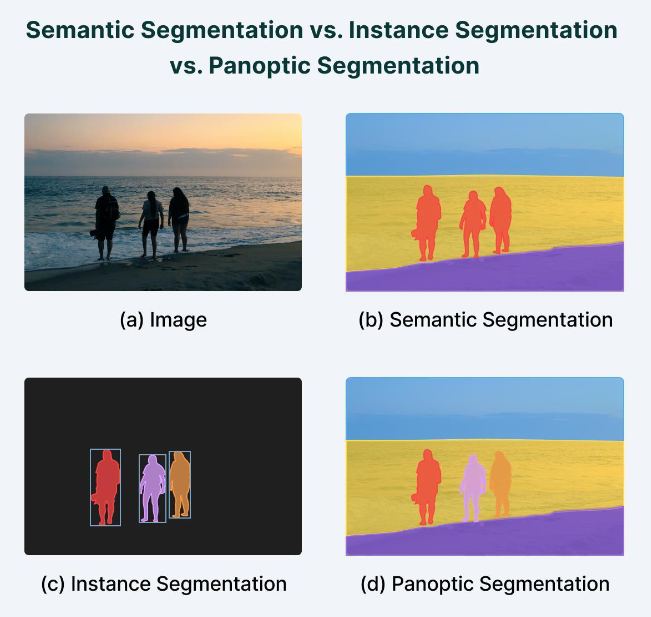

ref-https://www.ibm.com/topics/image-segmentation

### Traditional image segmentation techniques

1. Thresholding: Thresholding methods create binary images, classifying pixels based on whether their intensity is above or below a given “threshold value”.

2. Histograms: Histograms, which plot the frequency of certain pixel values in an image, are often used to define thresholds. For example, histograms can infer the values of background pixels, helping isolate object pixels.

3. Edge detection: Edge detection methods identify the boundaries of objects or classes by detecting discontinuities in brightness or contrast.

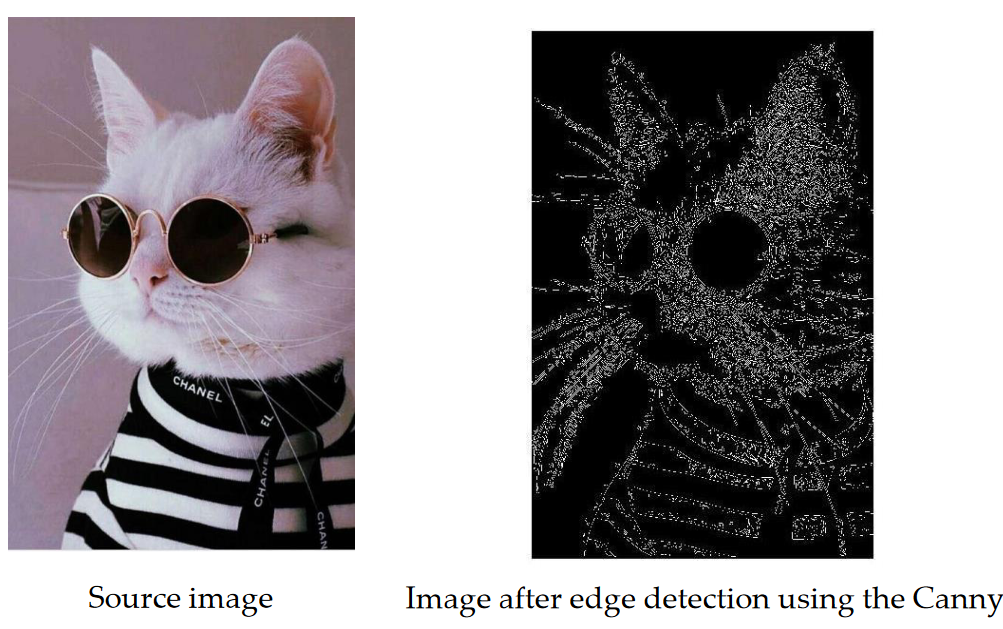

4. Watersheds: Watershed algorithms transform images into grayscale, then generate a topographical map in which each pixel’s “elevation” is determined by its brightness. Regions, boundaries and objects can be inferred from where “valleys”, “ridges” and “catchment basins” form.

5. Region-based segmentation: Starting with one or more “seed pixels”, region-growing algorithms group together neighboring pixels with similar characteristics. Algorithms can be agglomerative or divisive.

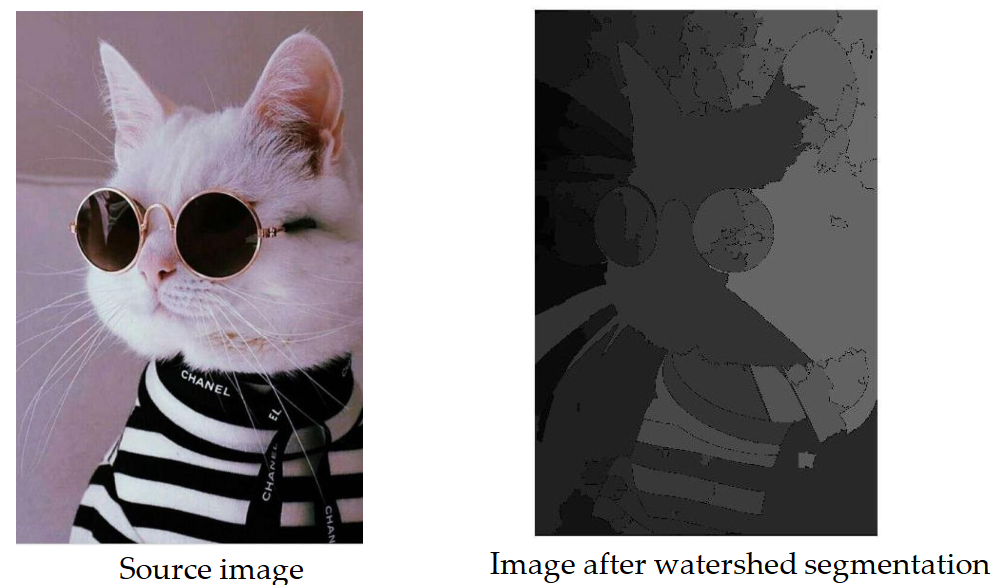

6. Clustering-based segmentation: An unsupervised learning method, clustering algorithms divide visual data into clusters of pixels with similar values. A common variant is K-means clustering, in which k is the number of clusters: pixel values are plotted as data points, and k random points are selected as center of a cluster (“centroid”). Each pixel is assigned to a cluster based on the nearest—that is, most similar—centroid. Centroids are then relocated to the mean of each cluster and the process is repeated, relocating centroids with each iteration until clusters have stabilized.

### Overview of traditional image segmentation techniques

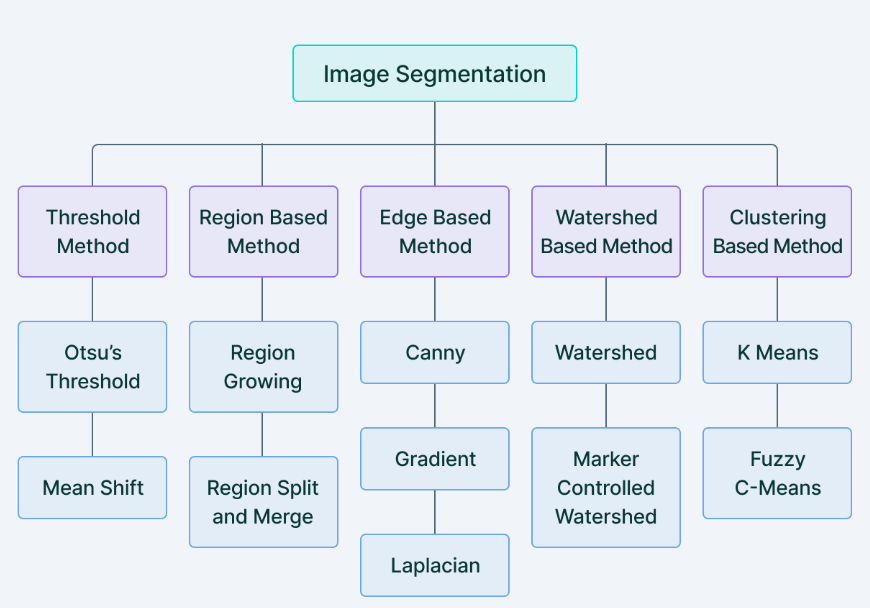

### Deep learning image segmentation

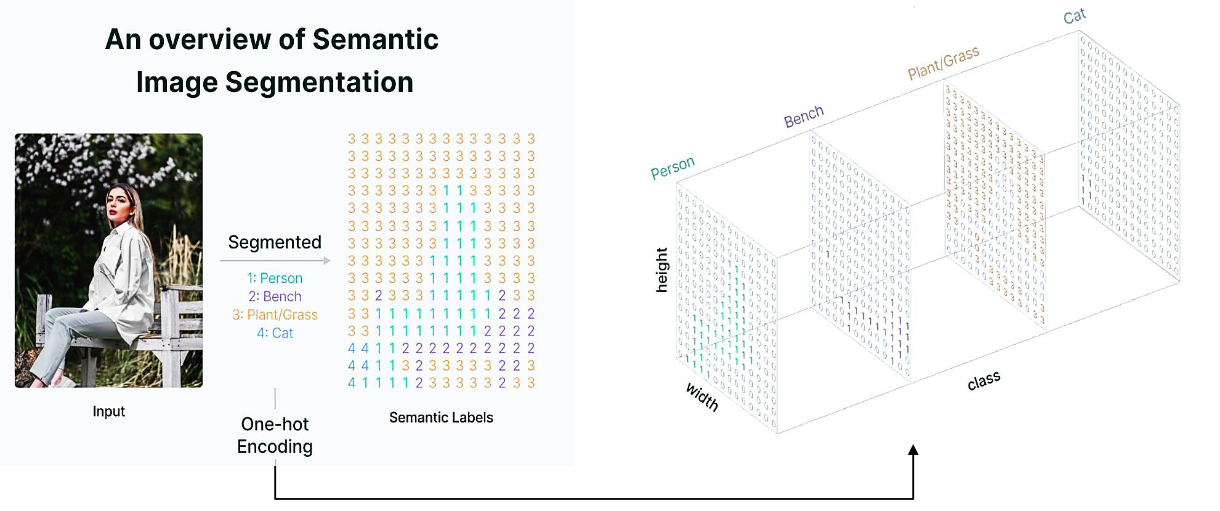

### Deep learning image segmentation models
Trained on an annotated dataset of images, the neural networks of deep learning image segmentation models discover underlying patterns in visual data and discern the salient features most relevant to classification, detection and segmentation.

Prominent deep learning models used in image segmentation include:

1. Fully Convolutional Networks (FCNs): FCNs, often used for semantic segmentation, are a type of convolutional neural network (CNN) with no fixed layers. An encoder network passes visual input data through convolutional layers to extract features relevant to segmentation or classification, and compresses (or downsamples) this feature data to remove non-essential information. This compressed data is then fed into decoder layers, upsampling the extracted feature data to reconstruct the input image with segmentation masks.

2. U-Nets: U-Nets modify FCN architecture to reduce data loss during downsampling with skip connections, preserving greater detail by selectively bypassing some convolutional layers as information and gradients move through the neural network. Its name is derived from the shape of diagrams demonstrating the arrangement of its layers.

3. Deeplab: Like U-Nets, Deeplab is a modified FCN architecture. In addition to skip connections, it uses diluted (or “atrous”) convolution to yield larger output maps without necessitating additional computational power.

4. Mask R-CNNs: Mask R-CNNs are a leading model for instance segmentation. Mask R-CNNs combine a region proposal network (RPN) that generates bounding boxes for each potential instance with an FCN-based “mask head” that generates segmentation masks within each confirmed bounding box.

5. Transformers: inspired by the success of transformer models like GPT and BLOOM in natural language processing, new models like Vision Transformer (ViT) using attention mechanisms in place of convolutional layers have matched or exceeded CNN performance for computer vision tasks.

**Let's see how U-Nets works**

In [1]:
!pwd

/content


In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-o_n3anb0
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-o_n3anb0
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=d02c88bebe9a82eac03918f011418b1382b819425a1ad701aed66f4ad9b30269
  Stored in directory: /tmp/pip-ephem-wheel-cache-vjfve318/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

**Download the Oxford-IIIT Pets dataset**
The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

    Class 1: Pixel belonging to the pet.
    Class 2: Pixel bordering the pet.
    Class 3: None of the above/a surrounding pixel.


In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNWY4CE/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNWY4CE/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


*The image color values are normalized to the [0, 1] range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.*

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

*The dataset already contains the required training and test splits, so continue to use the same splits:*

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

*The following class performs a simple augmentation by randomly-flipping an image.*

In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

*Build the input pipeline, applying the augmentation after batching the inputs:*

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

*Visualize an image example and its corresponding mask from the dataset:*

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

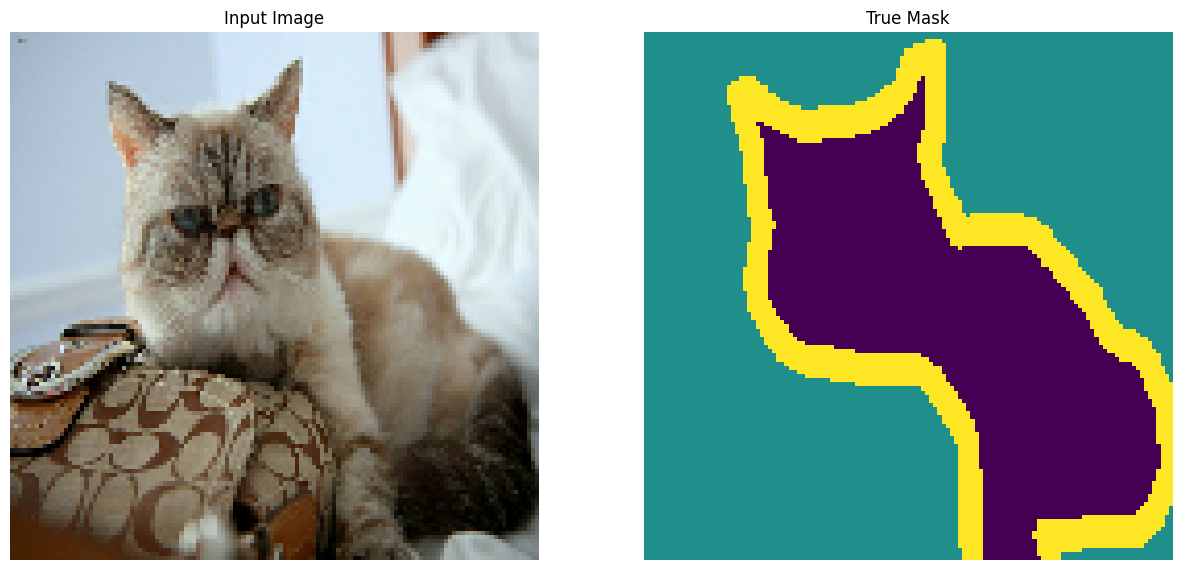

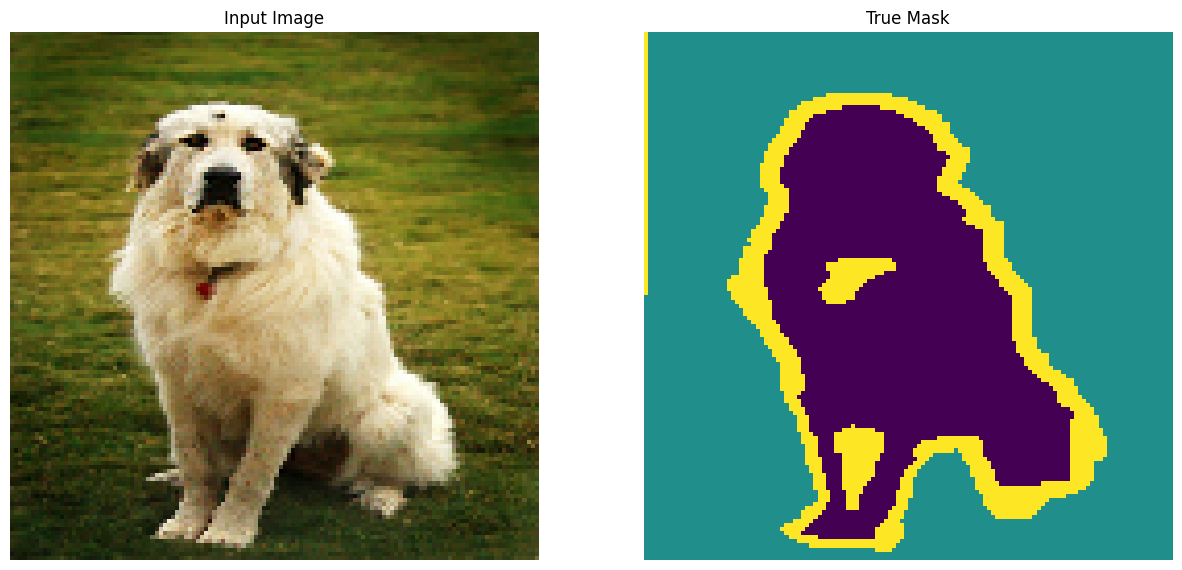

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

**Define the model**
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

**Train the model**

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

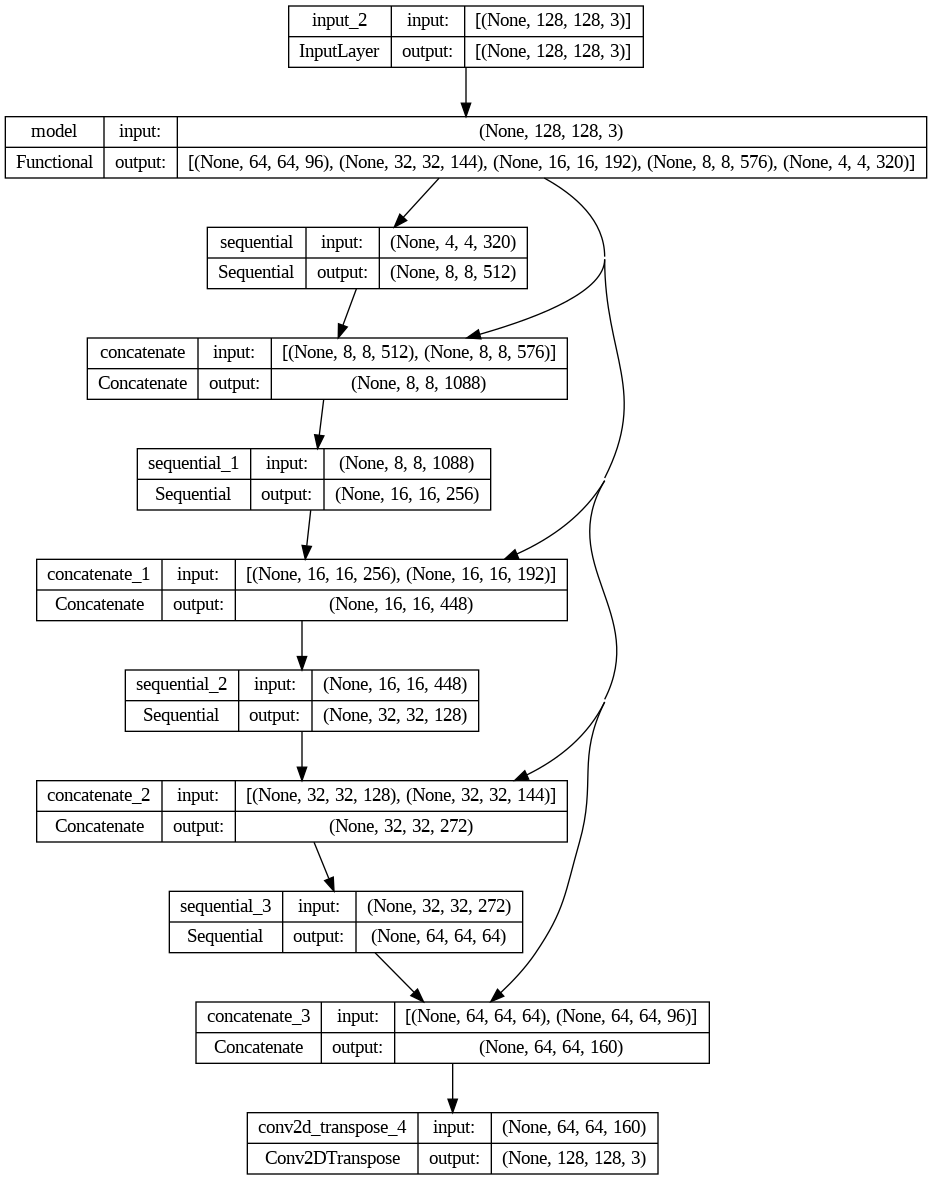

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

*Try out the model to check what it predicts before training:*

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 114ms/step


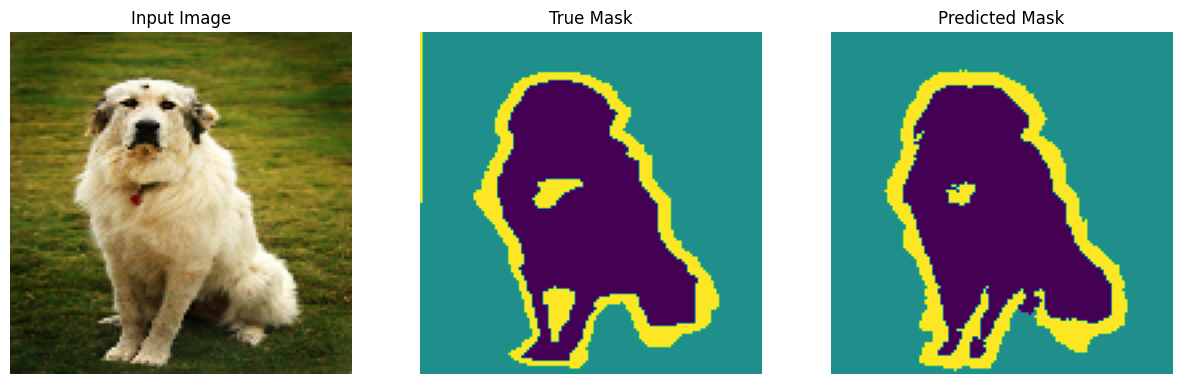


Sample Prediction after epoch 20

57/57 [==============================] - 415s 7s/step - loss: 0.1724 - accuracy: 0.9297 - val_loss: 0.2601 - val_accuracy: 0.9059


In [22]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

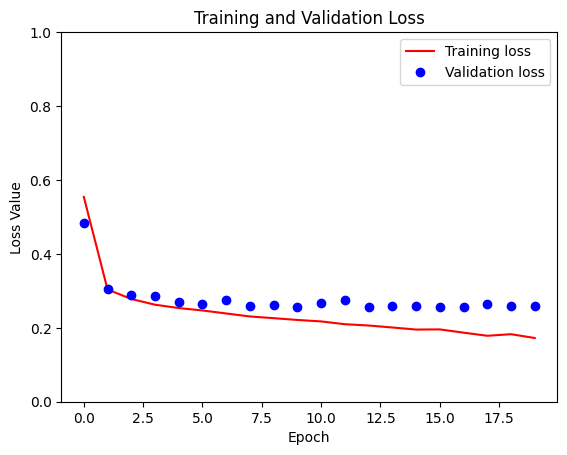

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**Make predictions**

2/2 [==============================] - 3s 1s/step


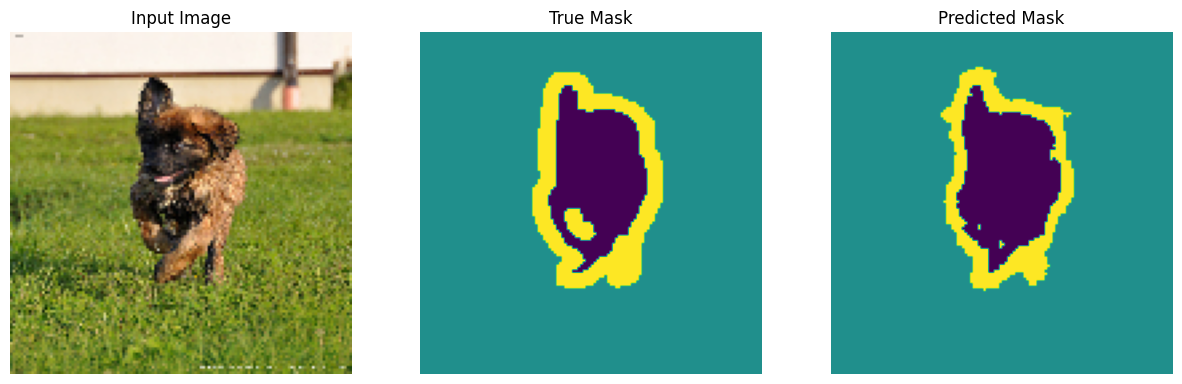

2/2 [==============================] - 3s 1s/step


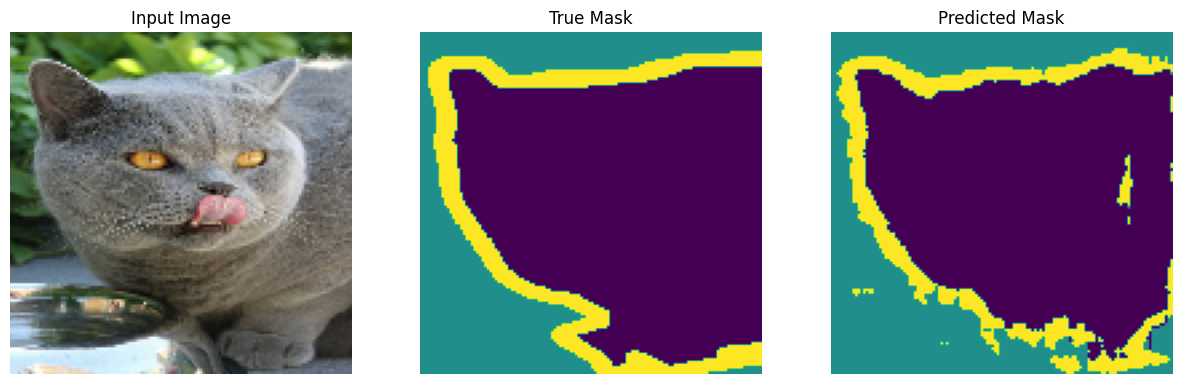

2/2 [==============================] - 2s 1s/step


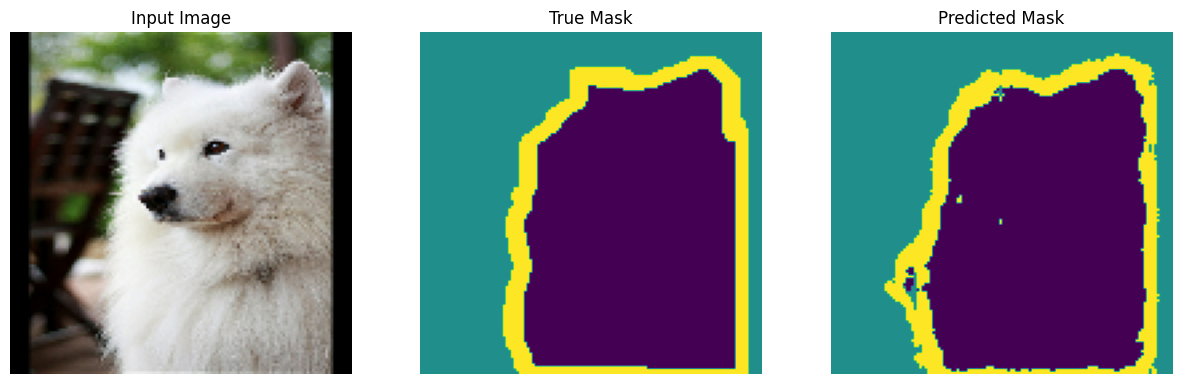

In [24]:
show_predictions(test_batches, 3)

**Imbalanced classes and class weights**
Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem.

In [25]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20
57/57 [==============================] - 376s 7s/step - loss: 0.2564 - accuracy: 0.9225
Epoch 2/20
57/57 [==============================] - 374s 7s/step - loss: 0.2599 - accuracy: 0.9217
Epoch 3/20
57/57 [==============================] - 373s 7s/step - loss: 0.2443 - accuracy: 0.9253
Epoch 4/20
57/57 [==============================] - 370s 6s/step - loss: 0.2323 - accuracy: 0.9284
Epoch 5/20
57/57 [==============================] - 370s 7s/step - loss: 0.2239 - accuracy: 0.9304
Epoch 6/20
57/57 [==============================] - 370s 7s/step - loss: 0.2194 - accuracy: 0.9316
Epoch 7/20
57/57 [==============================] - 369s 6s/step - loss: 0.2075 - accuracy: 0.9347
Epoch 8/20
57/57 [==============================] - 367s 6s/step - loss: 0.2061 - accuracy: 0.9350
Epoch 9/20
57/57 [==============================] - 370s 6s/step - loss: 0.1952 - accuracy: 0.9381
Epoch 10/20
57/57 [==============================] - 366s 6s/step - loss: 0.1958 - accuracy: 0.9380
Epoch 11/

In [26]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

In [27]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

*Now, you can train a model on this weighted dataset:*

In [28]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [29]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [30]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 70s 6s/step - loss: 0.3287 - accuracy: 0.6176
